#### This notebook is for interactively working with FluxNet and MiCASA data for viewing and preprocessing purposes.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import xarray as xr
import hvplot.xarray
import hvplot.pandas
from bokeh.models import DatetimeTickFormatter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import glob
import os

ERROR 1: PROJ: proj_create_from_database: Open of /usr/local/other/GEOSpyD/24.4.0-0_py3.12/2024-05-31/share/proj failed


## Define Variables / Import MetaData

In [2]:
# Define misc variables
amer_filepath = 'ameriflux-data/'
mic_filepath = 'intermediates/'
timedelta = 'DD'

In [3]:
# Import site metadata csv
meta_file = amer_filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only

## Functions

In [4]:
# Define a single match file location function
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

## Testing to break up groups for sbatch processing:

In [5]:
list = fluxnet_meta['Site ID'].to_list(); # get a list of all sites for preprocessing
len(list)

196

In [ ]:
# Divides a list into n (semi)equal groups
def split_into_groups(lst, n):
    k, m = divmod(len(lst), n)
    return [lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [ ]:
def check_same_elements(list1, list2):

    flat_list2 = [item for sublist in list2 for item in sublist]  # Flatten 2D list

    return set(list1) == set(flat_list2) 

In [ ]:
out = split_into_groups(list,5)

In [ ]:
# Check this worked
print(check_same_elements(list,out))

## Import FluxNet Data

In [6]:
# Define site ID
site_ID = 'CA-DB2'

In [7]:
# Import selected site daily subset data
sel_file = get_single_match(amer_filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
fluxnet_sel = pd.read_csv(sel_file)
print(fluxnet_sel.columns.values)

['TIMESTAMP' 'TA_F' 'TA_F_QC' 'SW_IN_POT' 'SW_IN_F' 'SW_IN_F_QC' 'LW_IN_F'
 'LW_IN_F_QC' 'VPD_F' 'VPD_F_QC' 'PA_F' 'PA_F_QC' 'P_F' 'P_F_QC' 'WS_F'
 'WS_F_QC' 'USTAR' 'USTAR_QC' 'NETRAD' 'NETRAD_QC' 'SW_OUT' 'SW_OUT_QC'
 'LW_OUT' 'LW_OUT_QC' 'CO2_F_MDS' 'CO2_F_MDS_QC' 'TS_F_MDS_1' 'TS_F_MDS_2'
 'TS_F_MDS_3' 'TS_F_MDS_4' 'TS_F_MDS_1_QC' 'TS_F_MDS_2_QC' 'TS_F_MDS_3_QC'
 'TS_F_MDS_4_QC' 'G_F_MDS' 'G_F_MDS_QC' 'LE_F_MDS' 'LE_F_MDS_QC' 'LE_CORR'
 'LE_CORR_25' 'LE_CORR_75' 'LE_RANDUNC' 'H_F_MDS' 'H_F_MDS_QC' 'H_CORR'
 'H_CORR_25' 'H_CORR_75' 'H_RANDUNC' 'NEE_VUT_REF' 'NEE_VUT_REF_QC'
 'NEE_VUT_REF_RANDUNC' 'NEE_VUT_25' 'NEE_VUT_50' 'NEE_VUT_75'
 'NEE_VUT_25_QC' 'NEE_VUT_50_QC' 'NEE_VUT_75_QC' 'RECO_NT_VUT_REF'
 'RECO_NT_VUT_25' 'RECO_NT_VUT_50' 'RECO_NT_VUT_75' 'GPP_NT_VUT_REF'
 'GPP_NT_VUT_25' 'GPP_NT_VUT_50' 'GPP_NT_VUT_75' 'RECO_DT_VUT_REF'
 'RECO_DT_VUT_25' 'RECO_DT_VUT_50' 'RECO_DT_VUT_75' 'GPP_DT_VUT_REF'
 'GPP_DT_VUT_25' 'GPP_DT_VUT_50' 'GPP_DT_VUT_75' 'RECO_SR' 'RECO_SR_N']


In [8]:
# select subset of columns + convert to datetime objects    
fluxnet_sel_sub = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF','NEE_VUT_REF_QC','GPP_NT_VUT_REF', 'GPP_DT_VUT_REF']].copy()
fluxnet_sel_sub['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_sub['TIMESTAMP'],format='%Y%m%d')
fluxnet_sel_sub = fluxnet_sel_sub.set_index('TIMESTAMP')

# Print raw data
fluxnet_sel_sub

,NEE_VUT_REF,NEE_VUT_REF_QC,GPP_NT_VUT_REF,GPP_DT_VUT_REF
TIMESTAMP,,,,
2019-01-01,0.126160,0.0,0.254793,-9999.000000
2019-01-02,-0.002189,0.0,0.541109,-9999.000000
2019-01-03,0.322132,0.0,0.239293,-9999.000000
2019-01-04,0.126160,0.0,0.383181,-9999.000000
2019-01-05,-0.002189,0.0,0.623230,-9999.000000
...,...,...,...,...
2020-12-27,0.325413,1.0,0.119893,0.090857
2020-12-28,-0.104131,1.0,0.496262,0.148202
2020-12-29,0.136947,1.0,0.203313,0.066766


In [9]:
# Check micasa units:
micasa_test = xr.open_dataset(get_single_match('micasa-data/daily-0.1deg-final/holding/daily/2024/01/MiCASA_v1_flux*20240101.nc4'))
micasa_test['NEE'].units, micasa_test['NPP'].units

('kg m-2 s-1', 'kg m-2 s-1')

In [12]:
# Make a clean output df
fluxnet_final = pd.DataFrame()

# NEE
## Convert units
## FluxNet NEE_VUT_REF in DD (gC m-2 d-1) to MiCASA (kgC m-2 s-1)
fluxnet_final['NEE (kgC m-2 s-1)'] = fluxnet_sel_sub['NEE_VUT_REF']*1e-3/86400

# GPP
## FluxNet GPP in DD (gC m-2 d-1) to MiCASA (kgC m-2 s-1)
fluxnet_final['GPP (DT) (kgC m-2 s-1)'] = fluxnet_sel_sub['GPP_DT_VUT_REF']*1e-3/86400
fluxnet_final['GPP (NT) (kgC m-2 s-1)'] = fluxnet_sel_sub['GPP_NT_VUT_REF']*1e-3/86400

## Mask bad QC values for NEE and GPP
## for daily FluxNet data, QC is fraction between 0-1, indicating percentage of measured and good quality gapfill data
fluxnet_final['NEE (kgC m-2 s-1)'] = fluxnet_final['NEE (kgC m-2 s-1)'].mask(fluxnet_sel_sub['NEE_VUT_REF_QC'] < 1, np.nan)
fluxnet_final['GPP (DT) (kgC m-2 s-1)'] = fluxnet_final['GPP (DT) (kgC m-2 s-1)'].mask(fluxnet_sel_sub['NEE_VUT_REF_QC'] < 1, np.nan)
fluxnet_final['GPP (NT) (kgC m-2 s-1)'] = fluxnet_final['GPP (NT) (kgC m-2 s-1)'].mask(fluxnet_sel_sub['NEE_VUT_REF_QC'] < 1, np.nan)

# Carry QC values into final 
fluxnet_final['NEE_VUT_REF_QC'] = fluxnet_sel_sub['NEE_VUT_REF_QC'] 

fluxnet_final.tail()

,NEE (kgC m-2 s-1),GPP (DT) (kgC m-2 s-1),GPP (NT) (kgC m-2 s-1),NEE_VUT_REF_QC
TIMESTAMP,,,,
2020-12-27,3.766354e-09,1.051582e-09,1.387650e-09,1.0
2020-12-28,-1.205220e-09,1.715301e-09,5.743773e-09,1.0
2020-12-29,1.585035e-09,7.727500e-10,2.353160e-09,1.0
2020-12-30,5.951146e-09,3.069745e-10,-7.888843e-10,1.0
2020-12-31,1.680567e-09,1.806076e-09,3.865984e-09,1.0


# Import MiCASA data

## NEE

In [13]:
# Import simplified MiCASA from data-extract.py
micasa_ds = pd.DataFrame()
for variable in ['NEE', 'NPP']:
    filename = f'{site_ID}_micasa_{variable}_{timedelta}.csv'
    path = os.path.join(mic_filepath, filename)
    ds = pd.read_csv(path,index_col=0)
    ds.index = pd.to_datetime(ds.index)
    varname = variable + ' (kgC m-2 s-1)'
    micasa_ds[varname] = ds

micasa_ds

,NEE (kgC m-2 s-1),NPP (kgC m-2 s-1)
time,,
2019-01-01,7.443131e-09,1.914935e-09
2019-01-02,7.468608e-09,2.148770e-09
2019-01-03,7.810228e-09,3.045570e-09
2019-01-04,7.757353e-09,3.502289e-09
2019-01-05,7.675730e-09,3.127462e-09
...,...,...
2020-12-27,9.817720e-09,8.526180e-10
2020-12-28,9.729192e-09,8.342989e-10
2020-12-29,9.026405e-09,6.002034e-10


## Explore NEE Data

In [14]:
# Append together
NEE_ds = pd.DataFrame()
NEE_ds['MiCASA'] = micasa_ds['NEE (kgC m-2 s-1)']
NEE_ds['FluxNet'] = fluxnet_final['NEE (kgC m-2 s-1)']

In [15]:
datetimeformatter = DatetimeTickFormatter(
    hours='%H:%M',
    days='%m/%d %H:%M',
    months='%b %Y',
    )

NEE_ds.hvplot(title = f'{site_ID} NEE (Daily Averages)',
              width=1200,height=500,
xformatter= datetimeformatter,
yformatter='%.1e',
ylabel = 'kg C m-2 s-1',
grid=True,
)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

## Explore NPP data

In [16]:
# Append together
NPP_ds = pd.DataFrame()
NPP_ds['MiCASA'] = micasa_ds['NPP (kgC m-2 s-1)']
NPP_ds['FluxNet DT GPP/2'] = fluxnet_final['GPP (DT) (kgC m-2 s-1)']/2

In [17]:
datetimeformatter = DatetimeTickFormatter(
    hours='%H:%M',
    days='%m/%d %H:%M',
    months='%b %Y',
    )

NPP_ds.hvplot(title = f'{site_ID} NPP (Daily Averages)',
              width=1200,height=500,
xformatter= datetimeformatter,
yformatter='%.1e',
ylabel = 'kgC m-2 s-1',
grid=True,
)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

<Axes: xlabel='TIMESTAMP'>

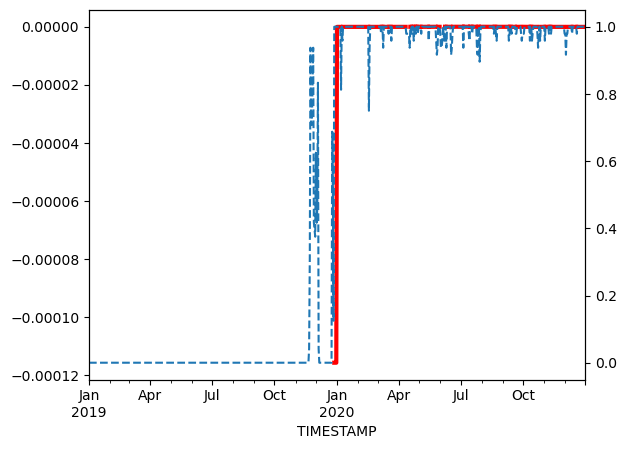

In [50]:
# What does the QC look like around here
fig, ax1 = plt.subplots()
CA_DB2_fluxnet['GPP (DT) (kgC m-2 s-1)'].plot(ax=ax1,color='red',lw=3)
ax2 = ax1.twinx()
CA_DB2_fluxnet['NEE_VUT_REF_QC'].plot(ax=ax2,zorder=0,ls='dashed')

# Let's try some other sites with this issue

In [47]:
def get_fluxnet_data(site_ID):
    # Import selected site daily subset data
    # site_lat = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
    # site_lon = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values
    sel_file = get_single_match(amer_filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
    fluxnet_sel = pd.read_csv(sel_file)

    # select subset of columns + convert to datetime objects    
    fluxnet_sel_sub = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF','NEE_VUT_REF_QC','GPP_NT_VUT_REF', 'GPP_DT_VUT_REF']].copy()
    fluxnet_sel_sub['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_sub['TIMESTAMP'],format='%Y%m%d')
    fluxnet_sel_sub = fluxnet_sel_sub.set_index('TIMESTAMP')
    
    # Make a clean output df
    fluxnet_final = pd.DataFrame()
    
    # NEE
    ## Convert units
    ## FluxNet NEE_VUT_REF in DD (gC m-2 d-1) to MiCASA (kgC m-2 s-1)
    fluxnet_final['NEE (kgC m-2 s-1)'] = fluxnet_sel_sub['NEE_VUT_REF']*1e-3/86400
    
    # GPP
    ## FluxNet GPP in DD (gC m-2 d-1) to MiCASA (kgC m-2 s-1)
    fluxnet_final['GPP (DT) (kgC m-2 s-1)'] = fluxnet_sel_sub['GPP_DT_VUT_REF']*1e-3/86400
    fluxnet_final['GPP (NT) (kgC m-2 s-1)'] = fluxnet_sel_sub['GPP_NT_VUT_REF']*1e-3/86400
    
    ## Mask bad QC values for NEE and GPP
    ## for daily FluxNet data, QC is fraction between 0-1, indicating percentage of measured and good quality gapfill data
    fluxnet_final['NEE (kgC m-2 s-1)'] = fluxnet_final['NEE (kgC m-2 s-1)'].mask(fluxnet_sel_sub['NEE_VUT_REF_QC'] < 1, np.nan)
    fluxnet_final['GPP (DT) (kgC m-2 s-1)'] = fluxnet_final['GPP (DT) (kgC m-2 s-1)'].mask(fluxnet_sel_sub['NEE_VUT_REF_QC'] < 1, np.nan)
    fluxnet_final['GPP (NT) (kgC m-2 s-1)'] = fluxnet_final['GPP (NT) (kgC m-2 s-1)'].mask(fluxnet_sel_sub['NEE_VUT_REF_QC'] < 1, np.nan)
    
    # Carry QC values into final 
    fluxnet_final['NEE_VUT_REF_QC'] = fluxnet_sel_sub['NEE_VUT_REF_QC'] 
    
    return fluxnet_final

In [48]:
CA_DBB_fluxnet = get_fluxnet_data('CA-DBB')

<Axes: xlabel='TIMESTAMP'>

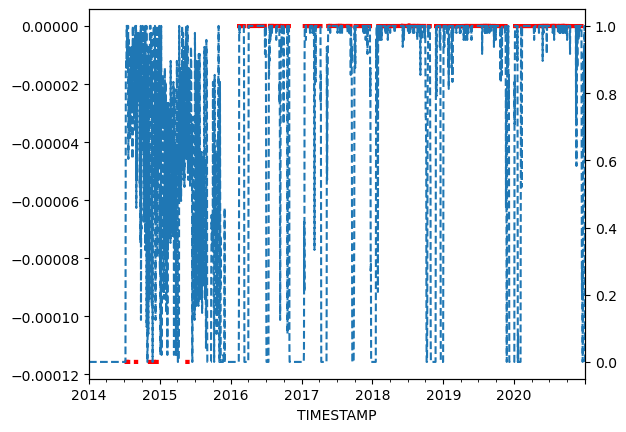

In [51]:
fig, ax1 = plt.subplots()
CA_DBB_fluxnet['GPP (DT) (kgC m-2 s-1)'].plot(ax=ax1,color='red',lw=3)
ax2 = ax1.twinx()
CA_DBB_fluxnet['NEE_VUT_REF_QC'].plot(ax=ax2,zorder=0,ls='dashed')

# No clear pattern - let's just throw out NPP outlier data

In [53]:
def replace_outliers_with_nan(df, column):
    """Replaces outliers in a DataFrame column with NaN.

    Args:
        df (pd.DataFrame): The DataFrame.
        column (str): The column name to check for outliers.

    Returns:
        pd.DataFrame: The DataFrame with outliers replaced by NaN.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].mask((df[column] < lower_bound) | (df[column] > upper_bound), np.nan)
    return df

In [58]:
CA_DB2_fluxnet_test = replace_outliers_with_nan(CA_DB2_fluxnet,'GPP (DT) (kgC m-2 s-1)')
CA_DB2_fluxnet_test['GPP (DT) (kgC m-2 s-1)'].hvplot()

:Curve   [TIMESTAMP]   (GPP (DT) (kgC m-2 s-1))

In [59]:
CA_DBB_fluxnet_test = replace_outliers_with_nan(CA_DBB_fluxnet,'GPP (DT) (kgC m-2 s-1)')
CA_DBB_fluxnet_test['GPP (DT) (kgC m-2 s-1)'].hvplot()

:Curve   [TIMESTAMP]   (GPP (DT) (kgC m-2 s-1))

## Display Site Info

In [ ]:
# Define subset site info to display
site_subset = ['Site ID', 
                'Name', 
                'Vegetation Description (IGBP)', 
                'Climate Class Description (Koeppen)', 
                'Elevation (m)',
                'Years of AmeriFlux FLUXNET Data']

In [ ]:
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

## Create final static plots

In [ ]:
# Create a subplot grid with specific width ratios
fig, axs = plt.subplots(4, 1, 
                         gridspec_kw={'height_ratios': [1, 2,0.25,2],
                                      'hspace': 0.01},
                         figsize=(10, 12)) 

# Define the map projection
proj = ccrs.PlateCarree()

site_lat = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

if site_lat >= 20:
    # North America extents
    min_lon, max_lon = -170, -57
    min_lat, max_lat = 25, 74

else:
    # South America extents
    min_lon, max_lon = -90, -30
    min_lat, max_lat = -60, 12
axs[0].axis('off')
axs[0] = plt.subplot(4, 1, 1, projection=proj,frameon=False)
axs[0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
# axs[0].add_feature(cfeature.STATES)
# axs[0].add_feature(cfeature.BORDERS)
axs[0].coastlines()

axs[0].scatter(site_lon,site_lat,
       marker='*', 
       s=500,
       color='yellow',
       edgecolor='black',
               zorder=3)
# axs[0].annotate(site_ID, (site_lon + 2,site_lat+2),
#             color='red',
#             bbox=dict(facecolor='white',edgecolor='None', pad=0.1,
#                      )
#            )

NEE_ds.plot(ax=axs[1],ylabel = 'NEE\n(kgC m$^{-2}$ s$^{-1}$)')

axs[2].set_visible(False)

NPP_ds.plot(ax=axs[3],ylabel = 'NPP\n(kgC m$^{-2}$ s$^{-1}$)')

date_format = mdates.DateFormatter('%b %Y')
for i in range(1,4,2):
    axs[i].xaxis.set_major_formatter(date_format)
    axs[i].set_xlabel('') 
fig.suptitle(f'{site_ID}',y=0.9,fontsize=14)

## Test South America Map only, no data

In [ ]:
site_ID = 'AR-TF1'

In [ ]:
# what are the min/maxes of lat/lon
print(fluxnet_meta['Latitude (degrees)'].min(), fluxnet_meta['Latitude (degrees)'].max())
print(fluxnet_meta['Longitude (degrees)'].min(), fluxnet_meta['Longitude (degrees)'].max())

In [ ]:
# Fix map to include all sites
# Create a subplot grid with specific width ratios
fig, axs = plt.subplots(4, 1, 
                         # subplot_kw={'projection': proj}, 
                         gridspec_kw={'height_ratios': [1.2, 2,0.25,2],
                                      'hspace': 0.01},
                         figsize=(10, 12)) 

# Define the map projection
proj = ccrs.PlateCarree()


site_lat = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values
# Pick map location based on location of site
if site_lat >= 20:
    # North America extents
    min_lon, max_lon = -170, -57
    min_lat, max_lat = 25, 74

else:
    # South America extents
    min_lon, max_lon = -90, -30
    min_lat, max_lat = -60, 12
axs[0].axis('off')
axs[0] = plt.subplot(4, 1, 1, projection=proj,frameon=False)
axs[0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
# axs[0].add_feature(cfeature.STATES)
# axs[0].add_feature(cfeature.BORDERS)
axs[0].coastlines() 

axs[0].scatter(site_lon,site_lat,
       marker='*', 
       s=300,
       color='yellow',
       edgecolor='black',
               zorder=3)

# Hide other axes
axs[1].remove()
axs[2].remove()
axs[3].remove()